--- 1. Carregando e Pré-processando os Dados ---
--- Pré-processamento Concluído ---

--- 2. Dividindo os Dados (Treino e Teste) ---
Tamanho do conjunto de Treino: 319
Tamanho do conjunto de Teste:  137

--- 3. Modelo 6: Refinando o Modelo 1 (Árvore Balanceada) ---
Iniciando a busca pelos melhores hiperparâmetros...
--- Busca Concluída ---

Melhores parâmetros encontrados: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 10}
Melhor pontuação (f1_macro) no treino (CV): 0.5497

--- 4. Avaliação Final do Modelo Refinado (Modelo 6) ---
Acurácia (Modelo 6 - Refinado): 0.5620

Relatório de Classificação (Modelo 6 - Refinado):
              precision    recall  f1-score   support

negativo (0)       0.75      0.56      0.64        96
positivo (1)       0.35      0.56      0.43        41

    accuracy                           0.56       137
   macro avg       0.55      0.56      0.54       137
weighted avg       0.63      0.56      

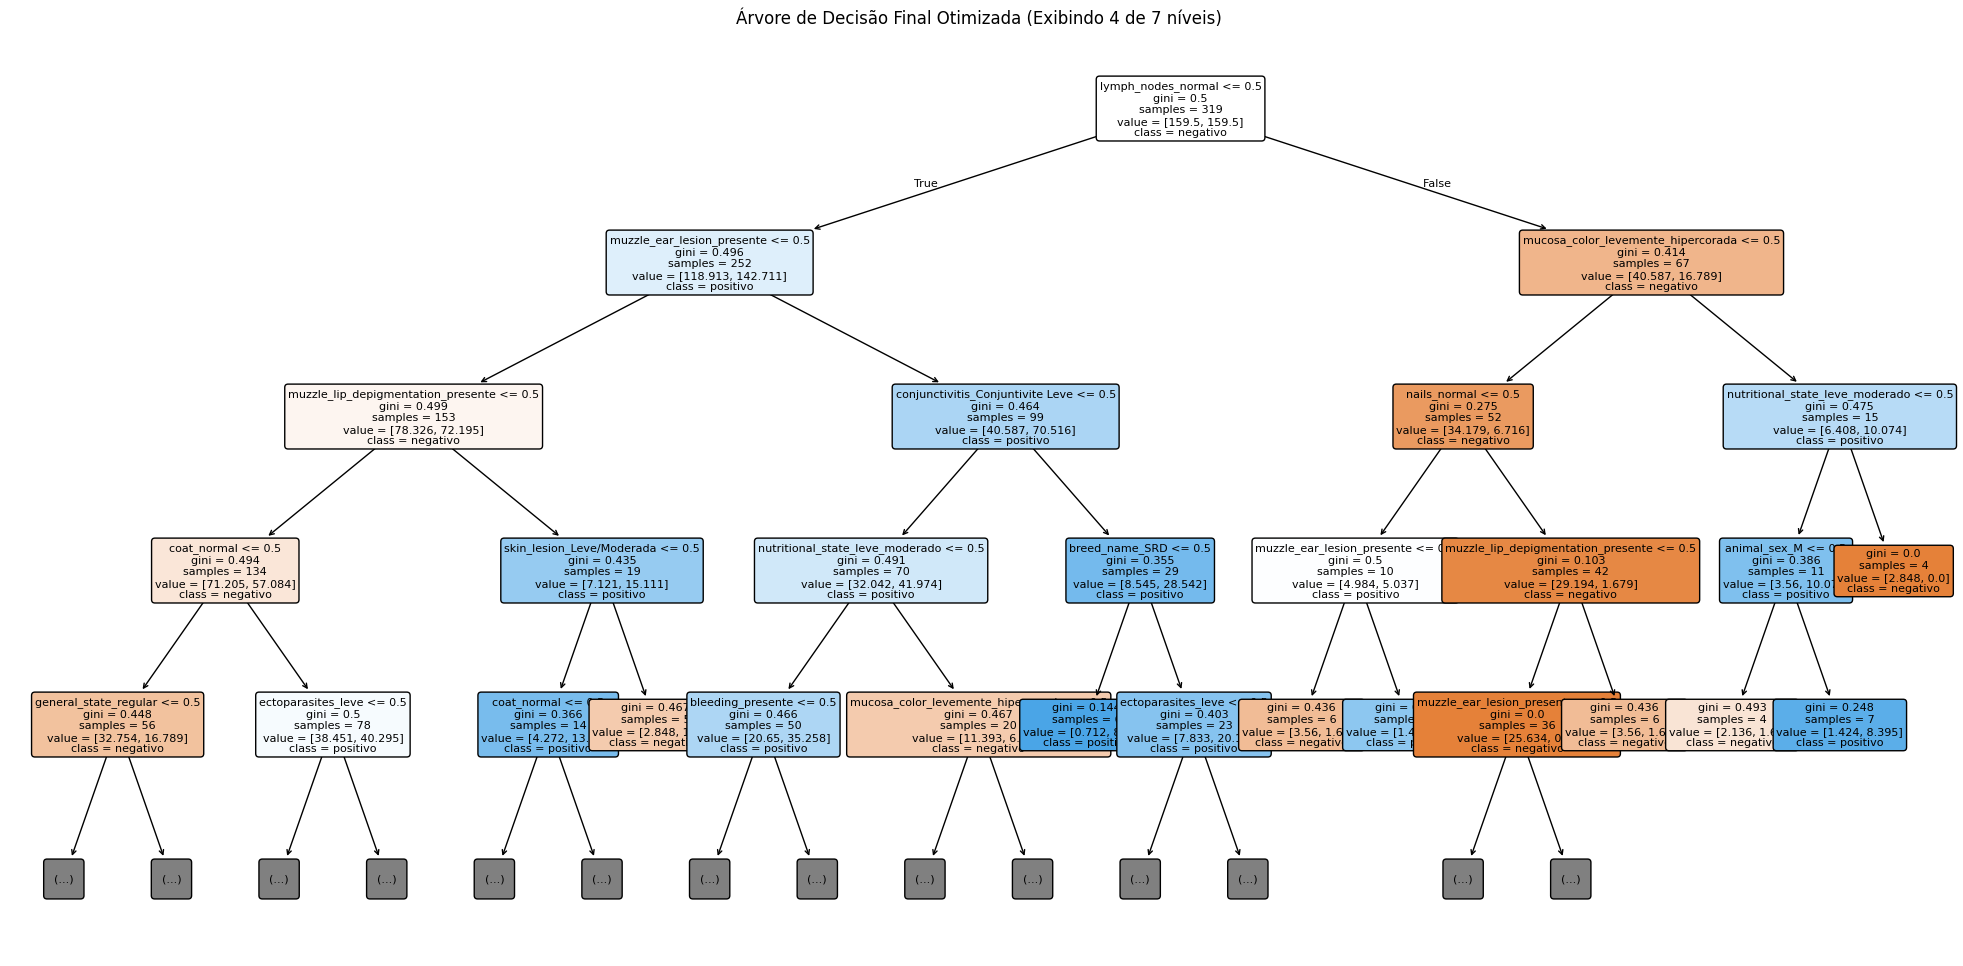

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    classification_report, 
    confusion_matrix, 
    make_scorer,  # Para criar nossa métrica de pontuação
    f1_score      # A métrica que queremos otimizar
)
import matplotlib.pyplot as plt

# ==============================================================================
# --- 1. Carregando e Pré-processando os Dados ---
# ==============================================================================
print("--- 1. Carregando e Pré-processando os Dados ---")

# ... (Seu código de carregamento e pré-processamento) ...
# (Ocultado por brevidade, mas é o mesmo código que você já tem)
# ... (Seu código de carregamento e pré-processamento) ...

# Carregar o dataset
file_path = '../data/raw/leish_dataset.csv'
df = pd.read_csv(file_path)

# Criar cópia para processamento
df_processed = df.copy()

# Lidar com valores ausentes (Missing)
for col in df_processed.select_dtypes(include=['object']).columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Codificar a variável Alvo (Target)
target_map = {'positivo': 1, 'negativo': 0, 'Unknown': 0}
df_processed['diagnosis'] = df_processed['diagnosis'].map(target_map).astype(int)

# Separar features (X) e alvo (y)
X_categorical = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# Aplicar One-Hot Encoding nas features categóricas
X_numeric = pd.get_dummies(X_categorical, drop_first=True, dtype=int)
feature_names = X_numeric.columns.tolist() # Salvar nomes das colunas

print("--- Pré-processamento Concluído ---")


# ==============================================================================
# --- 2. Dividindo os Dados (Treino e Teste) ---
# ==============================================================================
print("\n--- 2. Dividindo os Dados (Treino e Teste) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, 
    y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamanho do conjunto de Treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de Teste:  {X_test.shape[0]}")


# ==============================================================================
# --- 3. Modelo 6: Refinando o Campeão (GridSearchCV no Modelo 1) ---
# ==============================================================================
print("\n--- 3. Modelo 6: Refinando o Modelo 1 (Árvore Balanceada) ---")

# 1. Definir o "grid" de parâmetros
# Vamos focar em 'class_weight': ['balanced']
# e testar parâmetros ao redor do nosso 'max_depth=5'
param_grid = {
    'class_weight': ['balanced'],             # Fixo! Esta é a nossa descoberta chave.
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8],       # Testando valores ao redor do nosso '5'
    'min_samples_leaf': [1, 3, 5, 7, 10],  # Mínimo de amostras em uma folha
    'min_samples_split': [2, 5, 10]        # Mínimo para dividir um nó
}

# 2. Definir a métrica de sucesso (F1-Macro)
# Queremos o melhor equilíbrio, não a melhor acurácia.
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 3. Inicializar o GridSearchCV
grid_search_refined = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), # Modelo base
    param_grid=param_grid,                             # Parâmetros para testar
    scoring=f1_macro_scorer,                           # Métrica de sucesso (F1-Macro)
    cv=5,                                              # 5-fold cross-validation
    n_jobs=-1                                          # Usar todos os processadores
)

# 4. Treinar! (Isso pode demorar alguns segundos)
print("Iniciando a busca pelos melhores hiperparâmetros...")
grid_search_refined.fit(X_train, y_train)

# 5. Pegar o modelo campeão
best_dt_refined = grid_search_refined.best_estimator_

print("--- Busca Concluída ---")
print(f"\nMelhores parâmetros encontrados: {grid_search_refined.best_params_}")
print(f"Melhor pontuação (f1_macro) no treino (CV): {grid_search_refined.best_score_:.4f}")


# ==============================================================================
# --- 4. Avaliação Final (Modelo 6 - Refinado) ---
# ==============================================================================
print("\n--- 4. Avaliação Final do Modelo Refinado (Modelo 6) ---")

# Usar o modelo campeão para prever no conjunto de TESTE
y_pred_refined = best_dt_refined.predict(X_test)

# Calcular a Acurácia
print(f"Acurácia (Modelo 6 - Refinado): {accuracy_score(y_test, y_pred_refined):.4f}")

# Exibir Relatório de Classificação
print("\nRelatório de Classificação (Modelo 6 - Refinado):")
print(classification_report(y_test, y_pred_refined, target_names=['negativo (0)', 'positivo (1)']))

# Exibir Matriz de Confusão
print("\nMatriz de Confusão (Modelo 6 - Refinado):")
cm_refined = confusion_matrix(y_test, y_pred_refined)
print(f"            [Prev. Neg] [Prev. Pos]")
print(f"[Real Neg]  {cm_refined[0][0]:>10} {cm_refined[0][1]:>10}")
print(f"[Real Pos]  {cm_refined[1][0]:>10} {cm_refined[1][1]:>10}")


# ==============================================================================
# --- 5. Visualizando o Campeão Final ---
# ==============================================================================
print("\n--- 5. Visualizando o Modelo Campeão Final ---")

plt.figure(figsize=(25, 12)) # Figura grande para clareza

# Plotar a árvore
plot_tree(
    best_dt_refined, # O modelo campeão do GridSearchCV
    feature_names=feature_names,
    class_names=['negativo', 'positivo'],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4 # Limitar a 4 níveis para legibilidade (o modelo pode ser mais fundo)
)

plt.title(f"Árvore de Decisão Final Otimizada (Exibindo 4 de {best_dt_refined.get_depth()} níveis)")
plt.savefig("decision_tree_final_champion.png")
print("--- Visualização salva em 'decision_tree_final_champion.png' ---")
# plt.show()